# DLG Example with no additional security

In [1]:
# Correct virtual environment
# Should be path/to/federated-learning-security/venv/bin/python
!which python3

/Users/harrysharma/6CCS3PRJ/federated-learning-security/venv/bin/python3


## Libraries installed:
- `numpy`
- `matplotlib`
- `pytorch`
- `skimage`
- `torchvision`

In [2]:
import numpy as np
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)   
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on %s"%device)

2.5.1 0.20.1
Running on cpu


## Function Definition

In [3]:

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
    
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out
    
net = LeNet().to(device)
    
net.apply(weights_init)
criterion = cross_entropy_for_onehot

In [4]:
# Set-up image data to demonstrate gradient
image = Image.open("federated-learning-analysis/image/ywhach_ground_truth.png")
tp = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
])

tt = transforms.ToPILImage()

GT label is 0. 
Onehot label is 0.


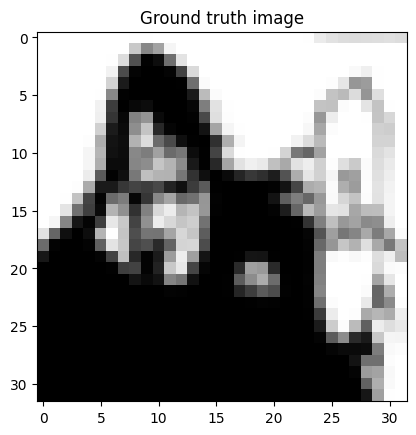

In [6]:
# Honest Participant
def label(image):
    gt_data = image.convert("RGB")
    gt_data = tp(gt_data).to(device)
    gt_data = gt_data.view(1, *gt_data.size())
    gt_label = torch.Tensor([0]).long().to(device)
    gt_label = gt_label.view(1, )
    gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

    plt.imshow(tt(gt_data[0].cpu()))
    plt.title("Ground truth image")
    print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

    return (gt_onehot_label,gt_data)

gt_onehot_label, gt_data = label(image)
# compute original gradient 
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())


# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

Dummy label is 27.


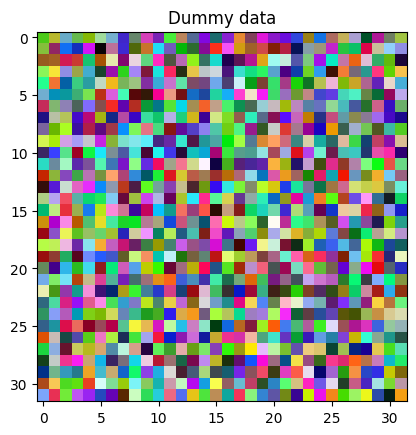

In [7]:
# generate dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

Mean Squared Error (MSE): 17588.440755208332
Peak Signal-to-Noise Ratio (PSNR): 5.678530206386618
Structural Similarity: 0.0073039380964315


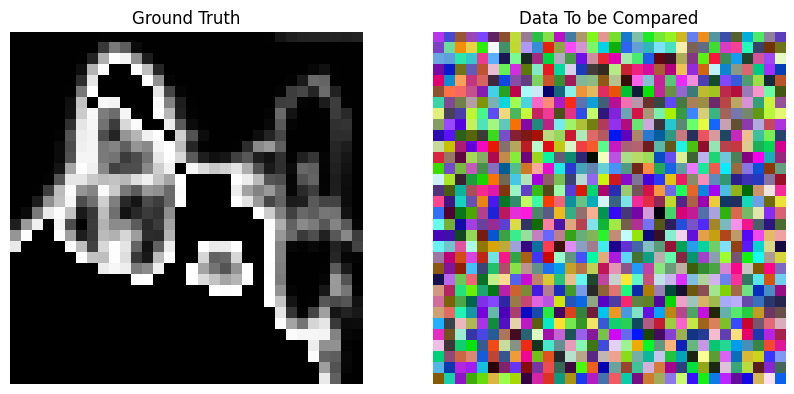

In [8]:
def check_similarity(d1, d2):
    ground_truth = np.array(d1)
    random_init = np.array(d2)

    ground_truth = (ground_truth * 255).astype(np.uint8)
    random_init = (random_init * 255).astype(np.uint8)

    mse = mean_squared_error(ground_truth, random_init)
    print(f"Mean Squared Error (MSE): {mse}")

    psnr = peak_signal_noise_ratio(ground_truth, random_init)
    print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr}")

    ssim,_ = structural_similarity(ground_truth, random_init, full=True, win_size=3)
    print(f"Structural Similarity: {ssim}")

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(ground_truth)
    axes[0].set_title('Ground Truth')
    axes[0].axis('off')

    axes[1].imshow(random_init)
    axes[1].set_title('Data To be Compared')
    axes[1].axis('off')

    plt.show()

ground_truth=tt(gt_data[0].cpu())
random_init=tt(dummy_data[0].cpu())
check_similarity(ground_truth, random_init)


In [10]:
optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data) 
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()
        # grad_diff = grad_diff / grad_count * 1000
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    if iters % 10 == 0: 
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
    history.append(tt(dummy_data[0].cpu()))

0 157.1435
10 57.6188
20 42.1448
30 32.1254
40 25.8779
50 21.3738
60 18.2787
70 16.1291
80 13.6204
90 12.2286
100 11.4078
110 10.7647
120 10.2664
130 9.7817
140 9.4117
150 9.1346
160 8.7962
170 8.5199
180 8.2879
190 8.1126
200 7.9487
210 7.8071
220 7.6105
230 7.4405
240 7.2828
250 7.1596
260 7.0322
270 6.8804
280 6.7649
290 6.6888


Dummy label is 0.


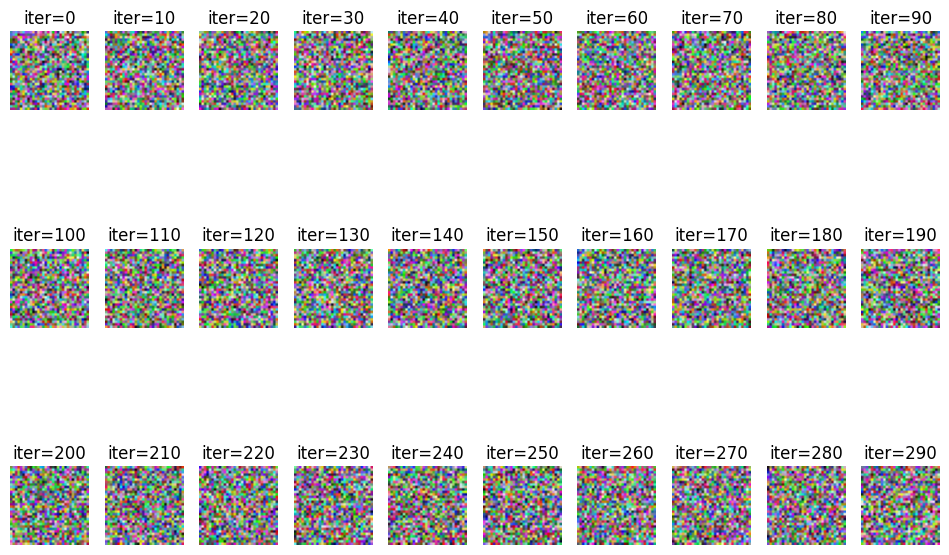

In [11]:
plt.figure(figsize=(12, 8))
for i in range(30):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[i * 10])
  plt.title("iter=%d" % (i * 10))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

Mean Squared Error (MSE): 17653.493815104168
Peak Signal-to-Noise Ratio (PSNR): 5.66249691117935
Structural Similarity: 0.018074712129872487


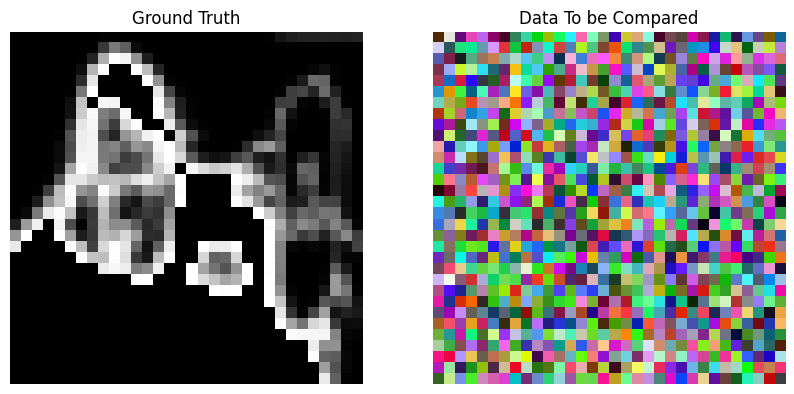

In [12]:
reconstructed_data = history[-1]
check_similarity(ground_truth,reconstructed_data)